In [1]:
# For changing directories to C++ programming and runnning files
import subprocess as sp
import os

# since using WSL2
os.environ['MPLCONFIGDIR'] = '/tmp/'

from multiprocessing import Pool

# Typical functionality for data manipulation and generation of latin hypercube
import numpy as np
from pyDOE import lhs
import emcee

# Gaussian Process emulator 
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.special as special
import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

# for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
sns.set("notebook")
%matplotlib inline
plt.style.use('default')

# data storage
import pandas as pd
import pickle

In [2]:
import sys
print(sys.platform)

linux


In [4]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [5]:
# My costumizations for plots
import matplotlib.font_manager
from matplotlib import rc
rc('font',**{'family':'serif', 'serif':['Computer Modern Roman']})
rc('text', usetex=True)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def costumize_axis(ax, x_title, y_title):
    ax.set_xlabel(x_title, fontsize=24)
    ax.set_ylabel(y_title, fontsize=24)
    ax.tick_params(axis='both', labelsize=18, top=True, right=True)
    ax.tick_params(axis='both', which='major', direction='in', length=8)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.tick_params(axis='both', which='minor', direction='in', length=4, top=True, right=True)
    return ax

In [6]:
# Others costumizations for plots
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(10, 10))
    fig.patch.set_facecolor('white')
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    costumize_axis(ax1, '', '')
    costumize_axis(ax2, '', '')
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y, color='blue')
    ax1.hist(X, color='blue', density=True)
    ax2.hist(Y, color='blue', orientation='horizontal', density=True)
    costumize_axis(ax, nameX, nameY)

# Defining the Model
This was actually done in `C++`, and this bit of code interface with the executable.

In [7]:
def PrintParametersFile(params_dict):
    '''
    Function ouputs file "params.txt" to the Code/util folder to be used by the
    Code/build/exact_solution.x program
    '''
    os.chdir('/mnt/c/Users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code')
    with open('./utils/params.txt', 'w') as fout:
        fout.write(f'tau_0 {params_dict["tau_0"]}\n')
        fout.write(f'Lambda_0 {params_dict["Lambda_0"]}\n')
        fout.write(f'alpha_0 {params_dict["alpha_0"]}\n')
        fout.write(f'xi_0 {params_dict["xi_0"]}\n')
        fout.write(f'ul {params_dict["tau_f"]}\n')
        fout.write(f'll {params_dict["tau_0"]}\n')
        fout.write(f'mass {params_dict["mass"]}\n')
        fout.write(f'eta_s {params_dict["eta_s"]}\n')
        fout.write(f'pl0 {params_dict["pl0"]}\n')
        fout.write(f'pt0 {params_dict["pt0"]}\n')
        fout.write(f'TYPE {params_dict["hydro_type"]}')
    os.chdir('/mnt/c/Users/gil-c/Documents/Heinz_Research/TeX-Docs/Rough-Drafts/Bayesian-Toy-Model/Code/scripts/')
    return 

def RunHydroSimulation():
    '''
    Function calls the C++ excecutable that run hydro calculations
    '''
    os.chdir('../')
    sp.run(['./build/exact_solution.x'], shell=True)
    os.chdir('scripts/')
    return

In [8]:
#default values for parameters
params = {
    'tau_0': 0.1,
    'Lambda_0': 1.647204044,
    'xi_0': -0.8320365099,
    'alpha_0': 0.654868759,
    'tau_f': 12.1,
    'mass': 1.015228426,
    'eta_s': 0.23873241463784,
    'pl0': 8.1705525351457684,
    'pt0': 1.9875332965147663,
    'hydro_type': 0
}

In [9]:
# function run runs hydro code to generate simualtion results for a set of 
# given parameters
def ProcessHydro(parameter_names, simulation_points, store_whole_file=False):
    out_list = []
    def GetFromOutputFiles(hydro_type):
        if hydro_type == 0:
            prefix = '../output/CE_hydro/'
            suffix = ''
        elif hydro_type == 1:
            prefix = '../output/DNMR_hydro/'
            suffix = ''
        elif hydro_type == 2:
            prefix = '../output/aniso_hydro/'
            suffix = ''
        elif hydro_type == 3:
            prefix = '../output/aniso_hydro/'
            suffix = '2'
        
        if store_whole_file:
            f_e = open(prefix + 'e' + suffix + '_m=0.200GeV.dat', 'r').readlines()
            f_pi = open(prefix + 'shear' + suffix + '_m=0.200GeV.dat', 'r').readlines()
            f_Pi = open(prefix + 'bulk' + suffix + '_m=0.200GeV.dat', 'r').readlines()
            
            out_list = []
            for i in range(len(f_e)):
                tau, e, pi, Pi = f_e[i].split()[0], f_e[i].split()[1], f_pi[i].split()[1], f_Pi[i].split()[1]
                out_list.append([float(tau), float(e), float(pi), float(Pi)])

            return np.array(out_list)
        else:
            f_e = open(prefix + 'e' + suffix + '_m=0.200GeV.dat', 'r')
            last_e = f_e.readlines()[-1]
            tau, e = last_e.split()[0], last_e.split()[1]
            f_e.close(); del last_e

            f_pi = open(prefix + 'shear' + suffix + '_m=0.200GeV.dat', 'r')
            last_pi = f_pi.readlines()[-1]
            pi = last_pi.split()[1]
            f_pi.close(); del last_pi

            f_Pi = open(prefix + 'bulk' + suffix + '_m=0.200GeV.dat', 'r')
            last_Pi = f_Pi.readlines()[-1]
            Pi = last_Pi.split()[1]
            f_Pi.close(); del last_Pi

            temp_list = [float(tau), float(e), float(pi), float(Pi)]
            return np.array(temp_list)

    def GetExactResults():
        f_exact = open('../output/exact/MCMC_calculation_moments.dat','r')
        if store_whole_file:
            return f_exact.readlines()
        else:
            t, e, pl, pt, p = f_exact.readlines()[-1].split()
            pi = (float(pt) - float(pl)) / 1.5
            Pi = (2 *  float(pt) + float(pl)) / 3 - float(p)
            temp_list = [float(t), float(e), pi, Pi]
            return temp_list

    if len(simulation_points) > len(parameter_names):
        for parameters in simulation_points:
            for i, name in enumerate(parameter_names):
                params[name] = parameters[i]
            PrintParametersFile(params)
            RunHydroSimulation()
            if params['hydro_type'] == 4:
                out_list.append(GetExactResults())
            else:
                out_list.append(GetFromOutputFiles(params['hydro_type']))

    else:
        for i, name in enumerate(parameter_names):
            params[name] = simulation_points[i]
        PrintParametersFile(params)
        RunHydroSimulation()
        if params['hydro_type'] == 4:
            return np.array(GetExactResults())
        else:
            return np.array(GetFromOutputFiles(params['hydro_type']))

    return np.array(out_list)


# Gaussian Process Regression
The training points and validation plots

In [10]:
# simulation times for generation of psuedo data
simulation_taus = np.array([5.1, 6.1, 7.1, 8.1, 9.1, 10.1, 11.1, 12.1])
eta_s = 5.0 / (4 * np.pi)
params['eta_s'] = eta_s
params['hydro_type'] = 4;
exact_out = []

read_in_exact = True
if read_in_exact:
    with open('exact_output_various_times.dat','r') as f:
        exact_out = np.array([[float(entry) for entry in line.split()] for line in f.readlines()])
else:

    # Need to improve to run calculation once, and then back track to the points we want to keep
    for i, tau in enumerate(simulation_taus):
        exact_out.append(ProcessHydro(['tau_f'], [tau]))
    
    with open('exact_output_various_times.dat','w') as f:
        for i, tau in enumerate(simulation_taus):
            for entry in exact_out[i]:
                f.write(f'{entry} ')
            if i != simulation_taus.size - 1:
                f.write('\n')



In [11]:
# Need to define latin hypercube sampling points and then run hydrodynamic simulation for all.
num_parameters_in_GP = 1 # Should be minimum of two to take into account relaxation time constant and ending time
GP_parameter_names = ['eta_s'] # Expand as needed
GP_parameter_names_math = [r'$\eta_s$']
# Make sure that order of ranges variable matches how they appear in names_of_GP_parameters
GP_parameter_ranges = np.array([[1 / (4 * np.pi), 10 / (4 * np.pi)]])
num_design_points = 40 * num_parameters_in_GP
unit = lhs(n=num_parameters_in_GP, samples=num_design_points, criterion='maximin')
GP_design_points = GP_parameter_ranges[:, 0] + unit * (GP_parameter_ranges[:, 1] - GP_parameter_ranges[:, 0])
GP_design_range = GP_parameter_ranges[:,1] - GP_parameter_ranges[:,0]
print(GP_design_range)

[0.71619724]


(array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]),
 array([0.08161004, 0.15252628, 0.22344251, 0.29435875, 0.36527498,
        0.43619122, 0.50710746, 0.57802369, 0.64893993, 0.71985616,
        0.7907724 ]),
 <BarContainer object of 10 artists>)

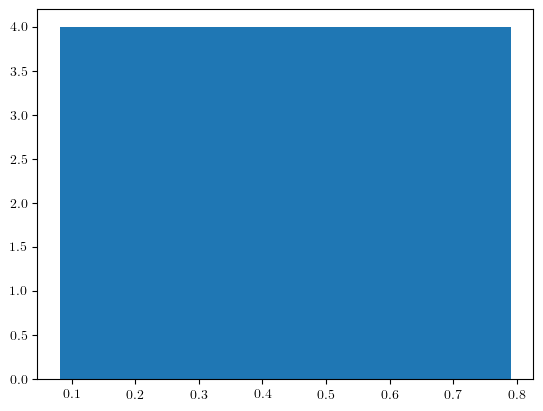

In [14]:
# fig, ax = plt.subplots(figsize=(10, 10))
# fig.patch.set_facecolor('white')
# ax.scatter(GP_design_points[:, 0], GP_design_points[:, 1])
# costumize_axis(ax, r'$\eta/\mathcal S$', r'$\tau_f$ [fm/c]')

#hist_1d_2d(GP_design_points[:, 0], GP_design_points[:, 1], r'$\eta/\mathcal S$', r'$\tau_f$ [fm/c]')
plt.hist(GP_design_points)

In [19]:
def design_log_prior(model_parameters, design_range):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array with shape (n,). Value of parameters used to evaluate model
    design_range        - 2d-array with shape (n,2). Give upper and lower limits of parameter values
    '''
    X  = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= np.array(design_range)[:,0])
    upper = np.all(X <= np.array(design_range)[:,1])

    if (lower and upper):
        return 0
    else:
        return -np.inf

def design_log_likelihood(y, cov):
    '''
    Parameters:
    ------------
    y   - 1d-array with shape (n,)
    cov - 2d-array with shape (n,n)
    '''
    # Use Cholesky decomposition for efficient lin alg algo
    L, info = lapack.dpotrf(cov, clean=True)

    if (info < 0):
        raise print('Error occured in computation of Cholesky decomposition')

    # Solve equation L*b=y
    b, info = lapack.dpotrs(L, np.array(y))

    if (info != 0):
        raise print('Error in inverting matrix equation')

    if np.all(L.diagonal() > 0):
        return -0.5 * np.dot(y, b) - np.log(L.diagonal()).sum()
    else:
        raise print('Diagonal has negative entry')

def design_log_posterior(model_parameters, design_range, design_points, design_points_error, truth, truth_error):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array like (n,)
    design_range        - 2d-array like (n,2)
    desing_points       - 1d-array like (3,), contains observables
    truth               - 1d-array like (3,), psuedo experimental data
    truth_error         - 1d-array like (3,), fake error-bar on psuedo-data
    '''
    y = design_points - truth
    # cov = 1e-5 * np.eye(3)
    cov = np.diag(design_points_error) ** 2
    cov += np.diag(truth_error) ** 2

    return design_log_prior(model_parameters, design_range) + design_log_likelihood(y, cov)


In [13]:
# ce = []    # 0
# dnmr = []  # 1
# vah = []   # 2
# mvah = []  # 3
hydro_mode = [0, 1, 2, 3]
names = ['ce', 'dnmr', 'vah', 'mvah']
read_in_simulation = True   # should false for first run
if read_in_simulation:
    with open('design_points_n=1.dat','r') as f:
        GP_design_points = np.array([[float(entry) for entry in line.split()] for line in f.readlines()])

    ce_simulations = []
    dnmr_simulations = []
    vah_simulations = []
    mvah_simulations = []

    for j, tau in enumerate(simulation_taus):
    
        with open(f'ce_simulation_points_n=1_tau={tau}.dat', 'r') as f:
            lines = f.readlines()
            ce_simulations.append(np.array([[float(entry) for entry in line.split()] for line in lines]))

        with open(f'dnmr_simulation_points_n=1_tau={tau}.dat', 'r') as f:
            lines = f.readlines()
            dnmr_simulations.append(np.array([[float(entry) for entry in line.split()] for line in lines]))

        with open(f'vah_simulation_points_n=1_tau={tau}.dat', 'r') as f:
            lines = f.readlines()
            vah_simulations.append(np.array([[float(entry) for entry in line.split()] for line in lines]))

        with open(f'mvah_simulation_points_n=1_tau={tau}.dat', 'r') as f:
            lines = f.readlines()
            mvah_simulations.append(np.array([[float(entry) for entry in line.split()] for line in lines]))

    full_simulations = dict((key, []) for key in names)
    for k, name in enumerate(names):
        for i, design_point in enumerate(GP_design_points):
            with open(f'full_outputs/{name}_full_output_C={design_point}.dat', 'r') as f:
                for line in f.readlines():
                    temp = []
                    for entry in line.split():
                        temp.append(float(entry))
                    full_simulations[name].append(temp)
else:
    global_last_output = dict((key, []) for key in names)
    global_full_output = dict((key, []) for key in names)

    tau_start = params['tau_0']
    delta_tau = tau_start / 20
    n_steps_1_fm = 1 / delta_tau
    params['tau_f'] = simulation_taus[-1]

    for i in range(4):
        params['hydro_type'] = i
        for design_point in GP_design_points:
            local_last_output = []
            hydro_output = ProcessHydro(parameter_names=GP_parameter_names, simulation_points=design_point, store_whole_file=True)
            for j in np.arange(int(simulation_taus[0]), int(simulation_taus[-1])+1, 1):
                local_last_output.append(hydro_output[int(j * n_steps_1_fm) - 1, :])
            global_last_output[names[i]].append(local_last_output)
            global_full_output[names[i]].append(hydro_output)   

    print(os.getcwd())
    with open('design_points_n=1.dat','w') as f:
        for line in GP_design_points:
            for entry in line:
                f.write(f'{entry} ')
            f.write(f'\n')

    for k, name in enumerate(names):
        for j, tau in enumerate(simulation_taus):
                with open(f'{name}_simulation_points_n=1_tau={tau}.dat', 'w') as f:
                    for line in np.array(global_last_output[name])[:, j, :]:
                        for entry in line:
                            f.write(f'{entry} ')
                        f.write('\n')

    for k, name in enumerate(names):
        for i, design_point in enumerate(GP_design_points):
            with open(f'full_outputs/{name}_full_output_C={design_point}.dat', 'w') as f:
                for line in np.array(global_full_output[name])[i]:
                    for entry in line:
                        f.write(f'{entry} ')
                    f.write('\n')
    

In [13]:
np.array(full_simulations['ce']).shape

(96000, 4)

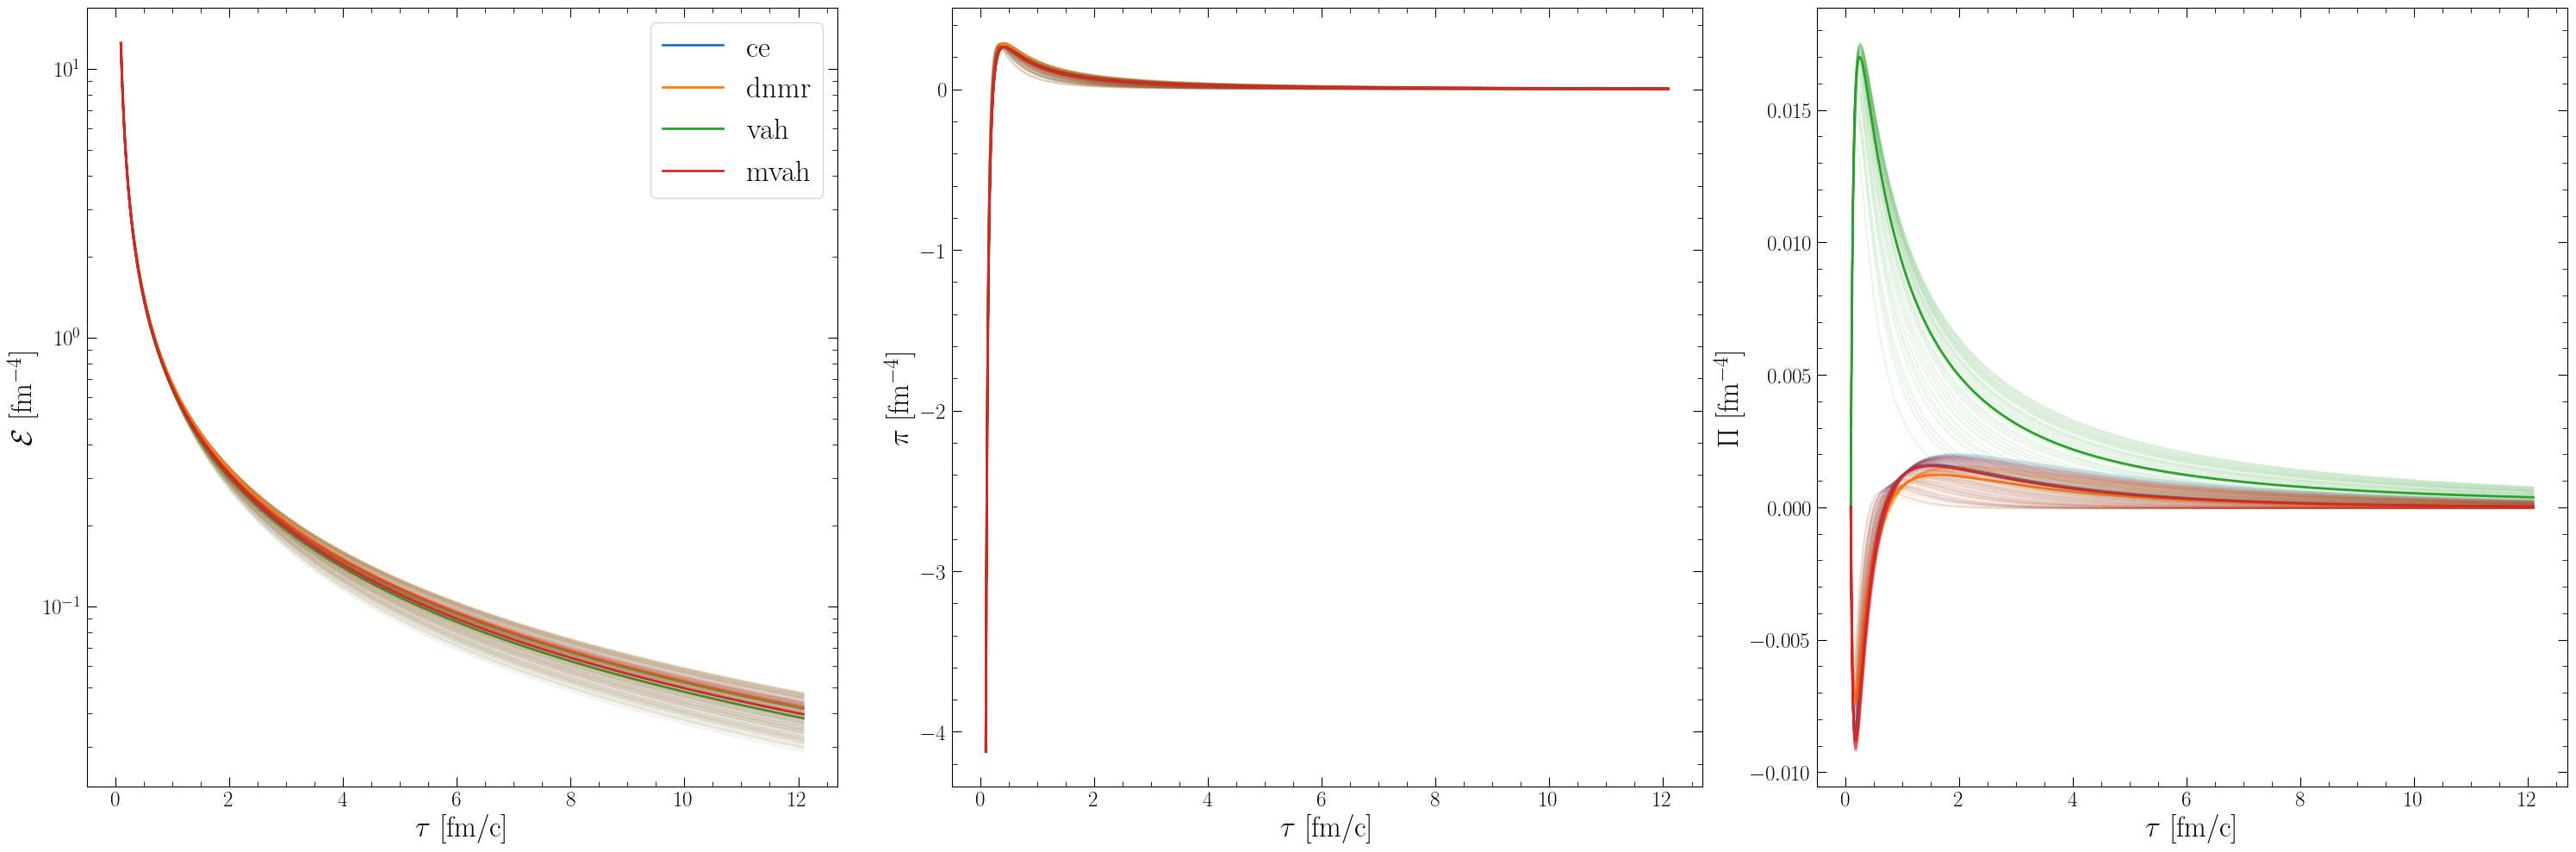

In [147]:
# make plots of total output
fig, ax = plt.subplots(1, 3, figsize=(30,10))
fig.patch.set_facecolor('white')
cmap = get_cmap(10, 'tab10')

delta_tau = params['tau_0'] / 20
steps = int((params['tau_f'] - params['tau_0']) / delta_tau)
rand_int = np.random.randint(0, num_design_points)
for i in range(3):
    for j, name in enumerate(names):
        data = np.array(full_simulations[name])
        for k in range(num_design_points - 1):
            # fancy logic since all output is stored in one go
            if k == rand_int: 
                ax[i].plot(data[k * steps : (k + 1) * steps - 1, 0], data[k * steps: (k + 1) * steps - 1, i+1], lw=2, color=cmap(j), label=name)
            else:
                ax[i].plot(data[k * steps : (k + 1) * steps - 1, 0], data[k * steps: (k + 1) * steps - 1, i+1], color=cmap(j), alpha=0.1)
costumize_axis(ax[0], r'$\tau$ [fm/c]', r'$\mathcal E$ [fm$^{-4}$]')
costumize_axis(ax[1], r'$\tau$ [fm/c]', r'$\pi$ [fm$^{-4}$]')
costumize_axis(ax[2], r'$\tau$ [fm/c]', r'$\Pi$ [fm$^{-4}$]')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right', fontsize=25)

fig.tight_layout()
# fig.savefig('plots/full_simulations.pdf')

In [16]:
hydro_lists = np.array([ce_simulations, dnmr_simulations, vah_simulations, mvah_simulations])

In [17]:
alpha_error = 1.0
exact_error = alpha_error * exact_out[:, 1:4]
exact_pseudo = np.array([[np.random.normal(loc=obv, scale=0.05 * obv) for obv in exact] for exact in exact_out])
for i, tau in enumerate(simulation_taus):
    exact_pseudo[i, 0] = tau
exact_pseudo

array([[5.10000000e+00, 1.07432285e-01, 1.47381831e-02, 3.96494807e-04],
       [6.10000000e+00, 8.52060552e-02, 9.86714407e-03, 2.45794357e-04],
       [7.10000000e+00, 6.50936017e-02, 7.53865953e-03, 1.74110439e-04],
       [8.10000000e+00, 6.25373279e-02, 6.01706967e-03, 1.14454609e-04],
       [9.10000000e+00, 5.67917945e-02, 5.00979465e-03, 7.63396111e-05],
       [1.01000000e+01, 4.73852892e-02, 4.48120390e-03, 5.00502268e-05],
       [1.11000000e+01, 4.33631251e-02, 3.49788515e-03, 2.37420549e-05],
       [1.21000000e+01, 3.53381387e-02, 3.07614414e-03, 1.06941295e-05]])

1.9678053930246328e+60 138.83202448772508
1.847195236434489e+60 138.76877397989423
5.885653736877106e+54 126.11211284150193
2.2322627760290066e+60 138.95812134842782


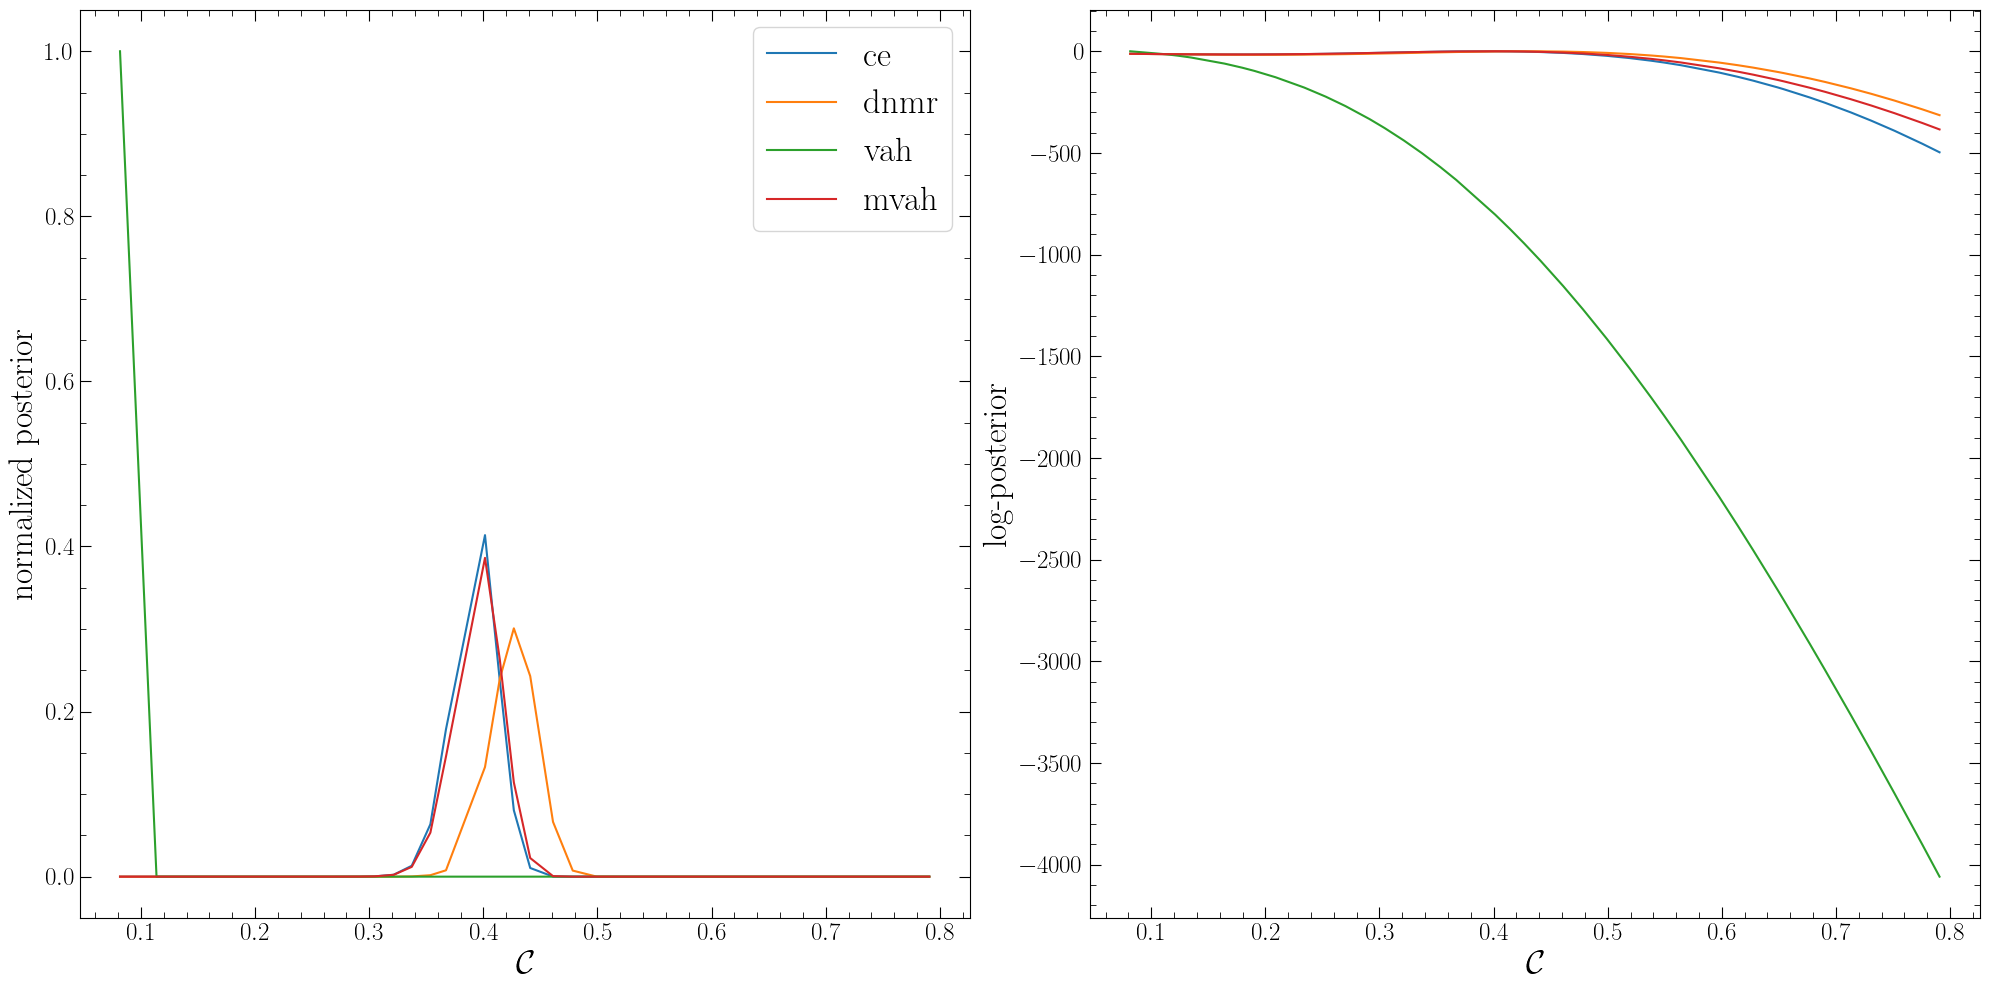

In [20]:
# make posteriors for GP_design points, given eta_s = 5. / (4 pi) and tau_f = 15
names = ['ce', 'dnmr', 'vah', 'mvah']
posteriors = {}
sort_arr = np.argsort(GP_design_points, 0)
for i, name in enumerate(names):
    final_arr = np.zeros(num_design_points)
    for j in range(num_design_points):
        post = 0
        for k, tau in enumerate(simulation_taus):
            design_point = GP_design_points[j]
            hydro_observables = hydro_lists[i, k, j, 1:4]
            hydro_observables_error = 0.0 * hydro_observables
            post += design_log_posterior(design_point, GP_parameter_ranges, hydro_observables, hydro_observables_error, exact_pseudo[k, 1:4], exact_error[k])
        final_arr[j] = post
    eta_s_posterior = final_arr[sort_arr[:,0]]
    posteriors[name] = np.array(eta_s_posterior)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i, name in enumerate(names):
    # include log-posterior plot
    # normalize data 
    print(np.max(np.exp(posteriors[name])), np.max(posteriors[name]))
    if True: #name != 'vah':
        ax[0].plot(GP_design_points[sort_arr[:,0]], np.exp(posteriors[name]) / np.sum(np.exp(posteriors[name])), label=name)
        ax[1].plot(GP_design_points[sort_arr[:,0]], posteriors[name] - np.max(posteriors[name]))
ax[0].legend(loc='upper right', fontsize=25)
costumize_axis(ax[0], r'$\mathcal C$', 'normalized posterior')
costumize_axis(ax[1], r'$\mathcal C$', 'log-posterior')
fig.tight_layout()

In [43]:
%%capture
if False:
    error_alpha = [100, 10, 1, 0.1, 0.01]
    for k, err in enumerate(error_alpha):
        # make posteriors for GP_design points, given eta_s = 5. / (4 pi) and tau_f = 15
        names = ['ce', 'dnmr', 'vah', 'mvah']
        posteriors = {}
        sort_arr = np.argsort(GP_design_points, 0)
        for i, name in enumerate(names):
            final_arr = np.zeros(num_design_points)
            for j in range(num_design_points):
                post = 0
                design_point = GP_design_points[j]
                for m, tau in enumerate(simulation_taus):
                    hydro_observables = hydro_lists[i, m, j, 1:4]
                    hydro_observables_error = 0.0 * hydro_observables
                    post += design_log_posterior(design_point, GP_parameter_ranges, hydro_observables, hydro_observables_error, exact_pseudo[m, 1:4], err * exact_out[m, 1:4])
                    final_arr[j] = post
            eta_s_posterior = final_arr[sort_arr[:,0]]
            posteriors[name] = np.array(eta_s_posterior)
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        for i, name in enumerate(names):
            ax.plot(GP_design_points[sort_arr[:,0]], np.exp(posteriors[name] - np.max(posteriors[name])), label=name)
        ax.plot([0.1], [-1], color='white', label=f'error bar = {100 * err}%')
        ax.legend(loc='upper right', fontsize=25)
        costumize_axis(ax, r'$\mathcal C$', '')
        fig.tight_layout()
        fig.savefig(f'plots/design_points_posterior-error={err}.pdf')


In [21]:
np.array(ce_simulations).shape

(8, 40, 4)

In [22]:
%%capture
emulators = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}

read_in_emulator = True
if read_in_emulator:
    pickle_file = open('emulator_data.pkl', 'rb')
    emulators = pickle.load(pickle_file)
else:
    f = open('emulator_scores.txt', 'w')
    pickle_file = open('emulator_data.pkl', 'wb')
    for i, name in enumerate(names):
        global_list = []
        for j, tau in enumerate(simulation_taus):
            local_list = []
            f.write(f'\tTraining GP for {name}')
            for m in range(1, 4):
                kernel = 1 * krnl.RBF(
                    length_scale=GP_design_range, 
                    length_scale_bounds=np.outer(np.array(GP_design_range), (1e-5, 1e1))) #+ \
                    # krnl.WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e1))
                GPR = gpr(kernel=kernel, n_restarts_optimizer=20)
                f.write(f'\t\tTraining GP: {i}')
                GPR.fit(GP_design_points, hydro_lists[i][j,:,m].reshape(-1,1))
                f.write('GP score: {:1.3f}'.format(GPR.score(GP_design_points, hydro_lists[i][j,:,m])))
                local_list.append(GPR)
            global_list.append(local_list)
        emulators[name] = global_list
    pickle.dump(emulators, pickle_file)

    f.close()
    pickle_file.close()

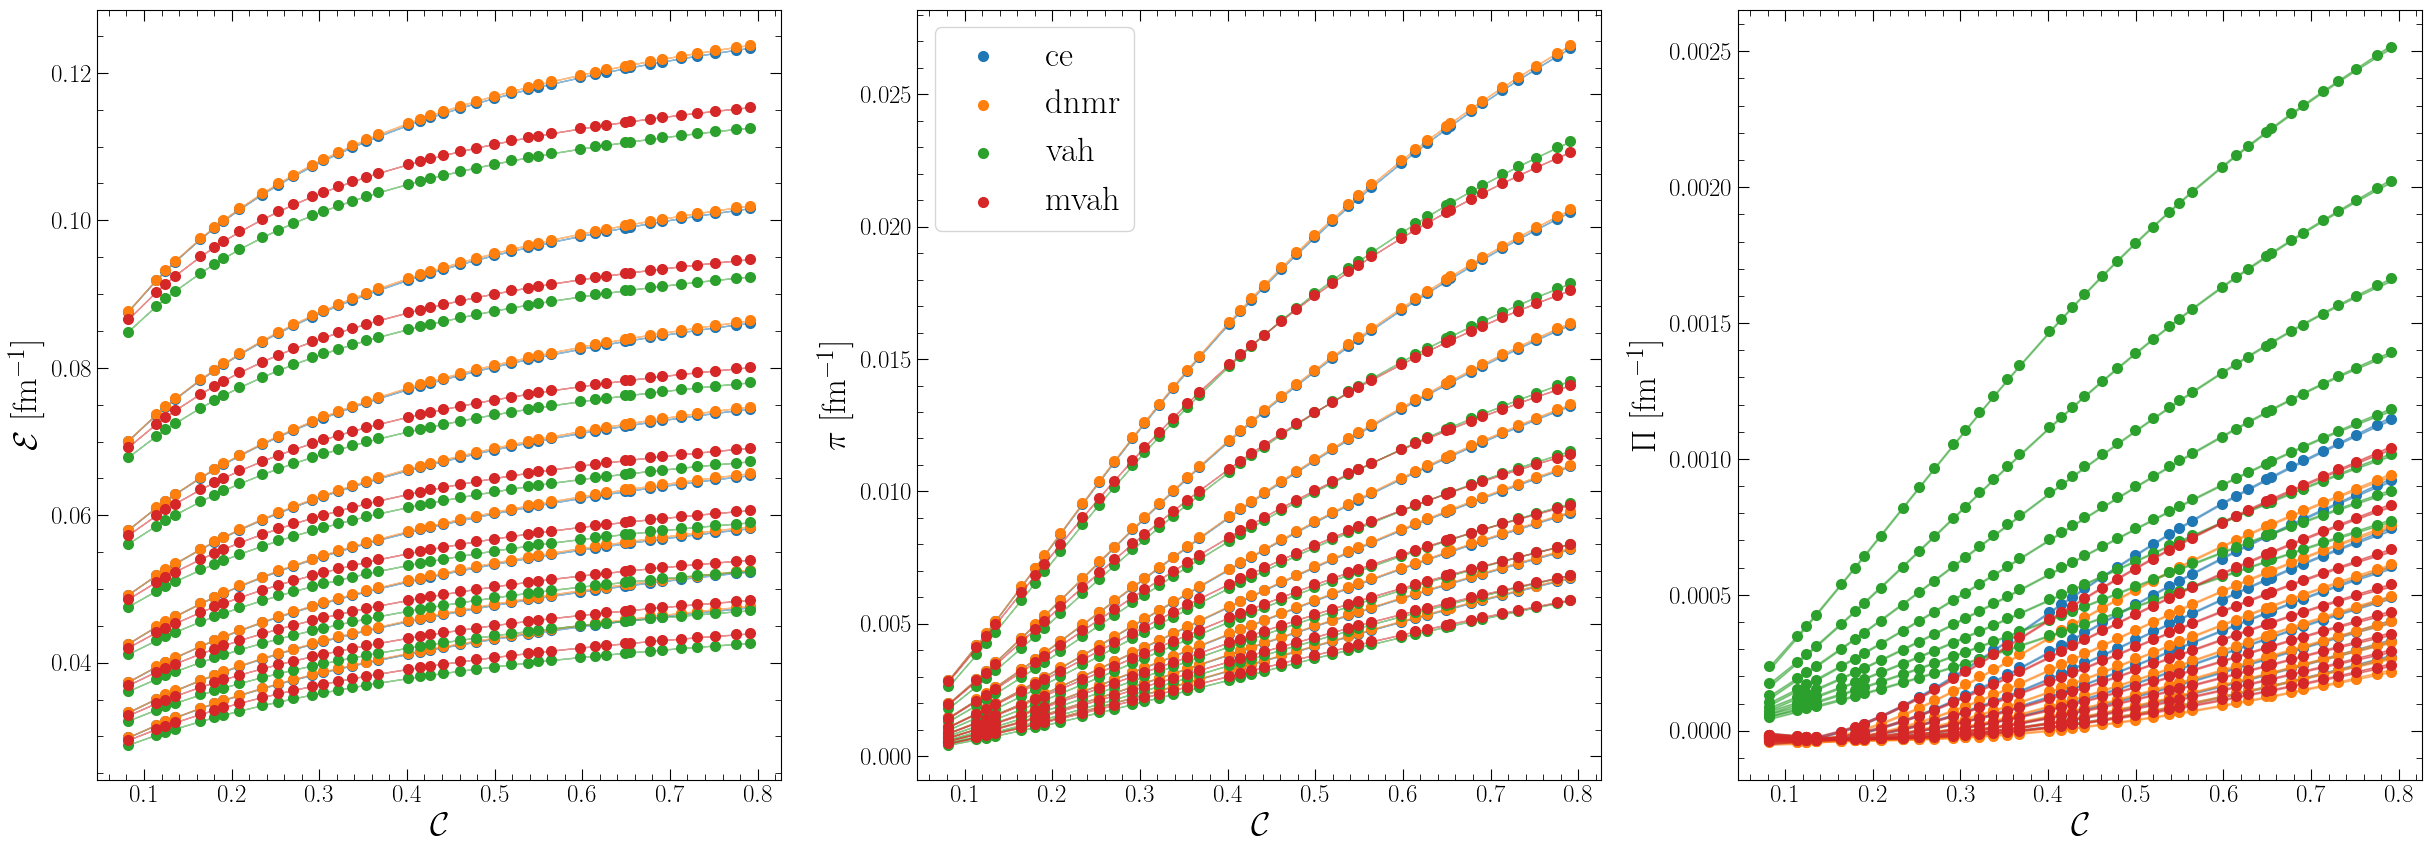

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(30,10))
fig.patch.set_facecolor('white')

names = ['ce', 'dnmr','vah','mvah']
observables = [r'$\mathcal E$ [fm$^{-1}$]', r'$\pi$ [fm$^{-1}$]', r'$\Pi$ [fm$^{-1}$]']
cmap = get_cmap(10, 'tab10')
for i, name in enumerate(names):
    for j, observable in enumerate(observables):
        for k, tau in enumerate(simulation_taus):
            if k == 0:
                ax[j].scatter(GP_design_points[sort_arr[:,0]], hydro_lists[i,k,sort_arr[:,0],j+1], lw=2, color=cmap(i), marker='o', label=name)
            else:
                ax[j].scatter(GP_design_points[sort_arr[:,0]], hydro_lists[i,k,sort_arr[:,0],j+1], lw=2, color=cmap(i), marker='o')
            #ax[i, j].scatter(GP_design_points, emulators[name][j].predict(GP_design_points, return_std=True)[0], lw=2, color='black', marker='x', label=name)
            emul, err = emulators[name][k][j].predict(GP_design_points, return_std=True)
            emul = emul.reshape(-1,)[sort_arr[:,0]]
            err = err[sort_arr[:,0]]
            ax[j].fill_between(GP_design_points.reshape(-1,)[sort_arr[:,0]], emul + err, emul - err, color=cmap(i), alpha=0.5)
            costumize_axis(ax[j], r'$\mathcal C$', observable)
ax[1].legend(loc='upper left', fontsize=25)


In [ ]:
#validation
if False:
    number_validation_points = 10
    tau_f = np.full((number_validation_points, 1), 15)
    eta_s = np.array(GP_parameter_ranges[0,0] + np.random.rand(number_validation_points, 1) * GP_design_range[0])
    eta_s = eta_s[np.argsort(eta_s, 0)[:,0]]
    validation_points = eta_s.reshape(-1, 1)

    names = ['ce', 'dnmr', 'vah', 'mvah']

    validation_data = {}
    for i, name in enumerate(names):
        params['hydro_type'] = i
        validation_data[name] = ProcessHydro(GP_parameter_names, validation_points)

    GP_predictions = {'ce': [], 'dnmr': [], 'vah': [], 'mvah': []}
    for name in names:
        for i in range(3):
            GP_x_prediction, GP_x_err = emulators[name][i].predict(validation_points, return_std=True)
            GP_predictions[name].append(np.hstack((GP_x_prediction, GP_x_err.reshape(-1,1))))

    # validation plot 1
    fig, ax = plt.subplots(4, 3, figsize=(30,40))
    fig.patch.set_facecolor('white')

    names = ['ce', 'dnmr','vah','mvah']
    observables = [r'$\mathcal E$ [fm$^{-1}$]', r'$\pi$ [fm$^{-1}$]', r'$\Pi$ [fm$^{-1}$]']
    cmap = get_cmap(10, 'tab10')
    for i, name in enumerate(names):
        for j, observable in enumerate(observables):
            for k, tau in enumerate(simulation_taus):
                # GP data
                # ax[i,j].scatter(GP_design_points[sort_arr[:,0]], hydro_lists[i,sort_arr[:,0],j+1], lw=2, color='gray', marker='o', label=name)
                emul, err = emulators[name][k][j].predict(GP_design_points, return_std=True)
                emul = emul.reshape(-1,)[sort_arr[:,0]]
                err = err[sort_arr[:,0]]
                ax[i, j].fill_between(GP_design_points.reshape(-1,)[sort_arr[:,0]], emul + err, emul - err, color='black', alpha=0.4)
                # Validation data
                ax[i,j].scatter(validation_points[:,0], np.array(validation_data[name])[:, j+1], lw=2, color=cmap(i), label=name)
                # ax[i,j].fill_between(validation_points[:,0], GP_predictions[name][j][:, 0] + GP_predictions[name][j][:, 1], GP_predictions[name][j][:, 0] - GP_predictions[name][j][:, 1], color=cmap(i), alpha=0.5)
                costumize_axis(ax[i,j], r'$\eta_\mathcal S$ ', observable)
    ax[0, 0].legend(loc=0, fontsize=25)
    
    # valaidation plot 2
    fig, ax = plt.subplots(1, 3, figsize=(30,10))
    fig.patch.set_facecolor('white')

    names = ['ce', 'dnmr','vah','mvah']
    observables = [r'$\mathcal E$ [fm$^{-1}$]', r'$\pi$ [fm$^{-1}$]', r'$\Pi$ [fm$^{-1}$]']
    cmap = get_cmap(10, 'tab10')
    for i, name in enumerate(names):
        for j, observable in enumerate(observables):
            ax[j].scatter(validation_points[:,0], np.array(validation_data[name])[:, j+1], lw=2, color=cmap(i), label=name)
            ax[j].fill_between(validation_points[:,0], GP_predictions[name][j][:, 0] + GP_predictions[name][j][:, 1], GP_predictions[name][j][:, 0] - GP_predictions[name][j][:, 1], color=cmap(i), alpha=0.5)
            costumize_axis(ax[j], r'$\eta_\mathcal S$ ', observable)
    ax[0].legend(loc=0, fontsize=25)

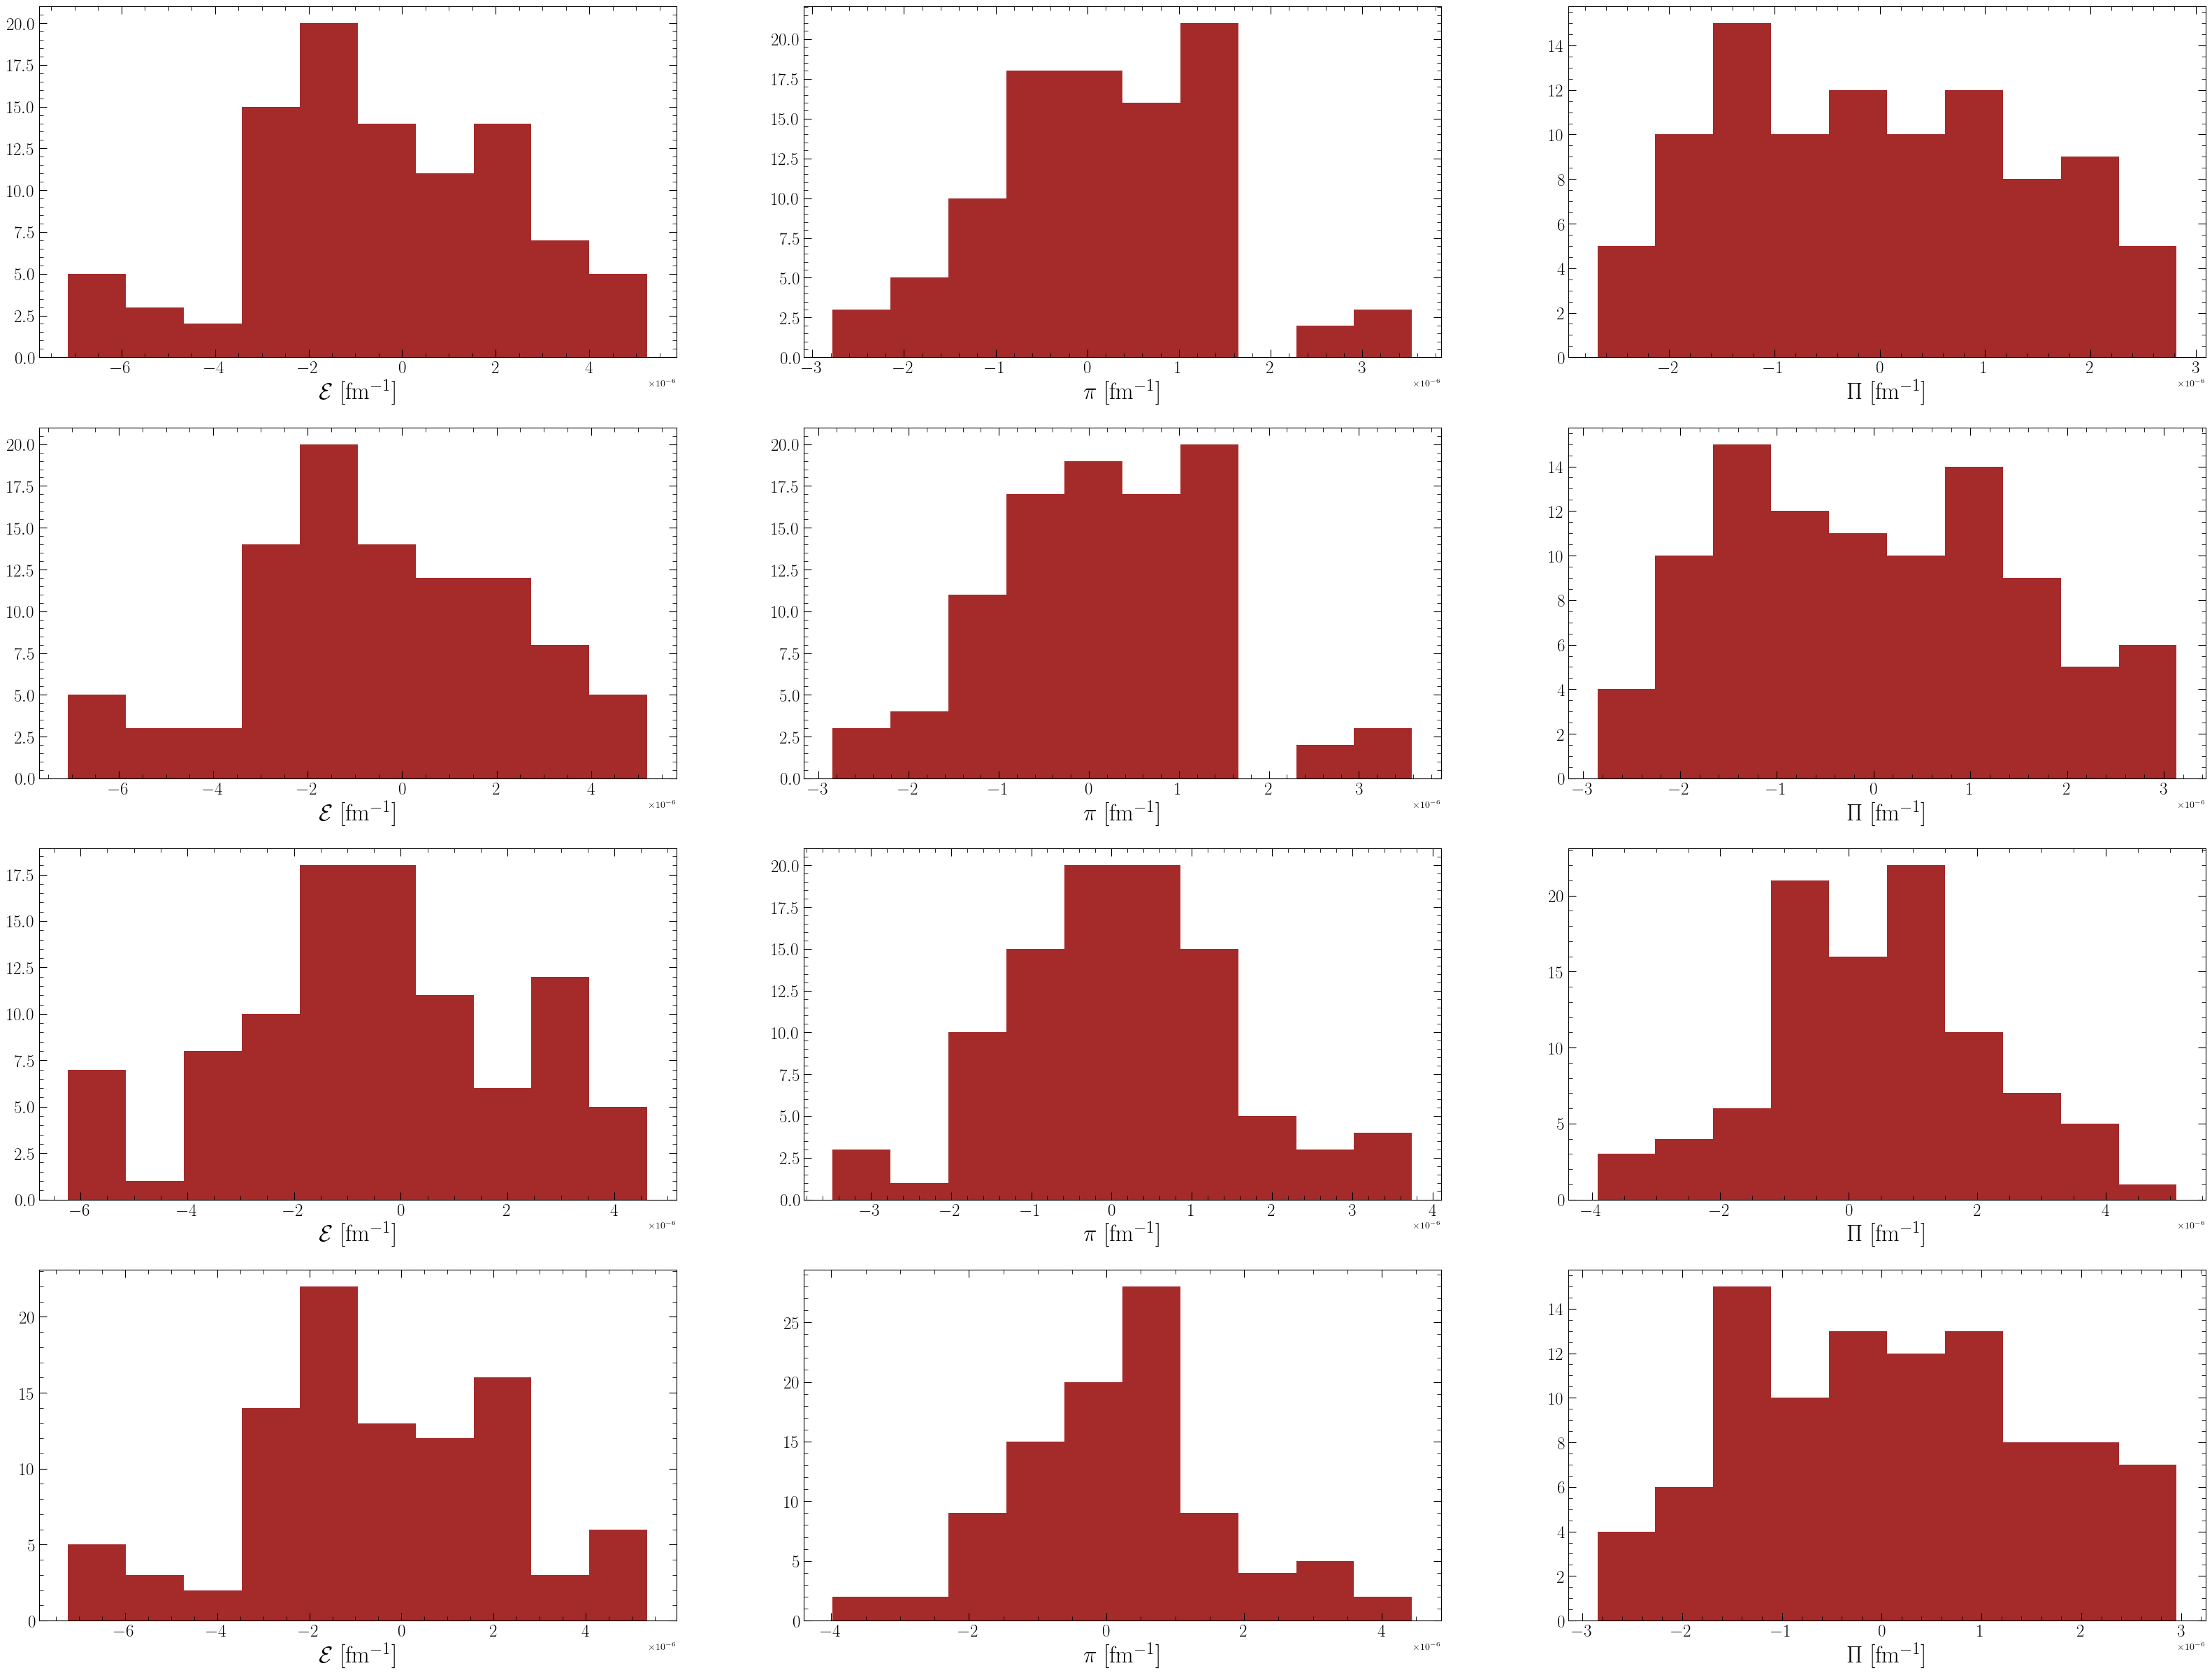

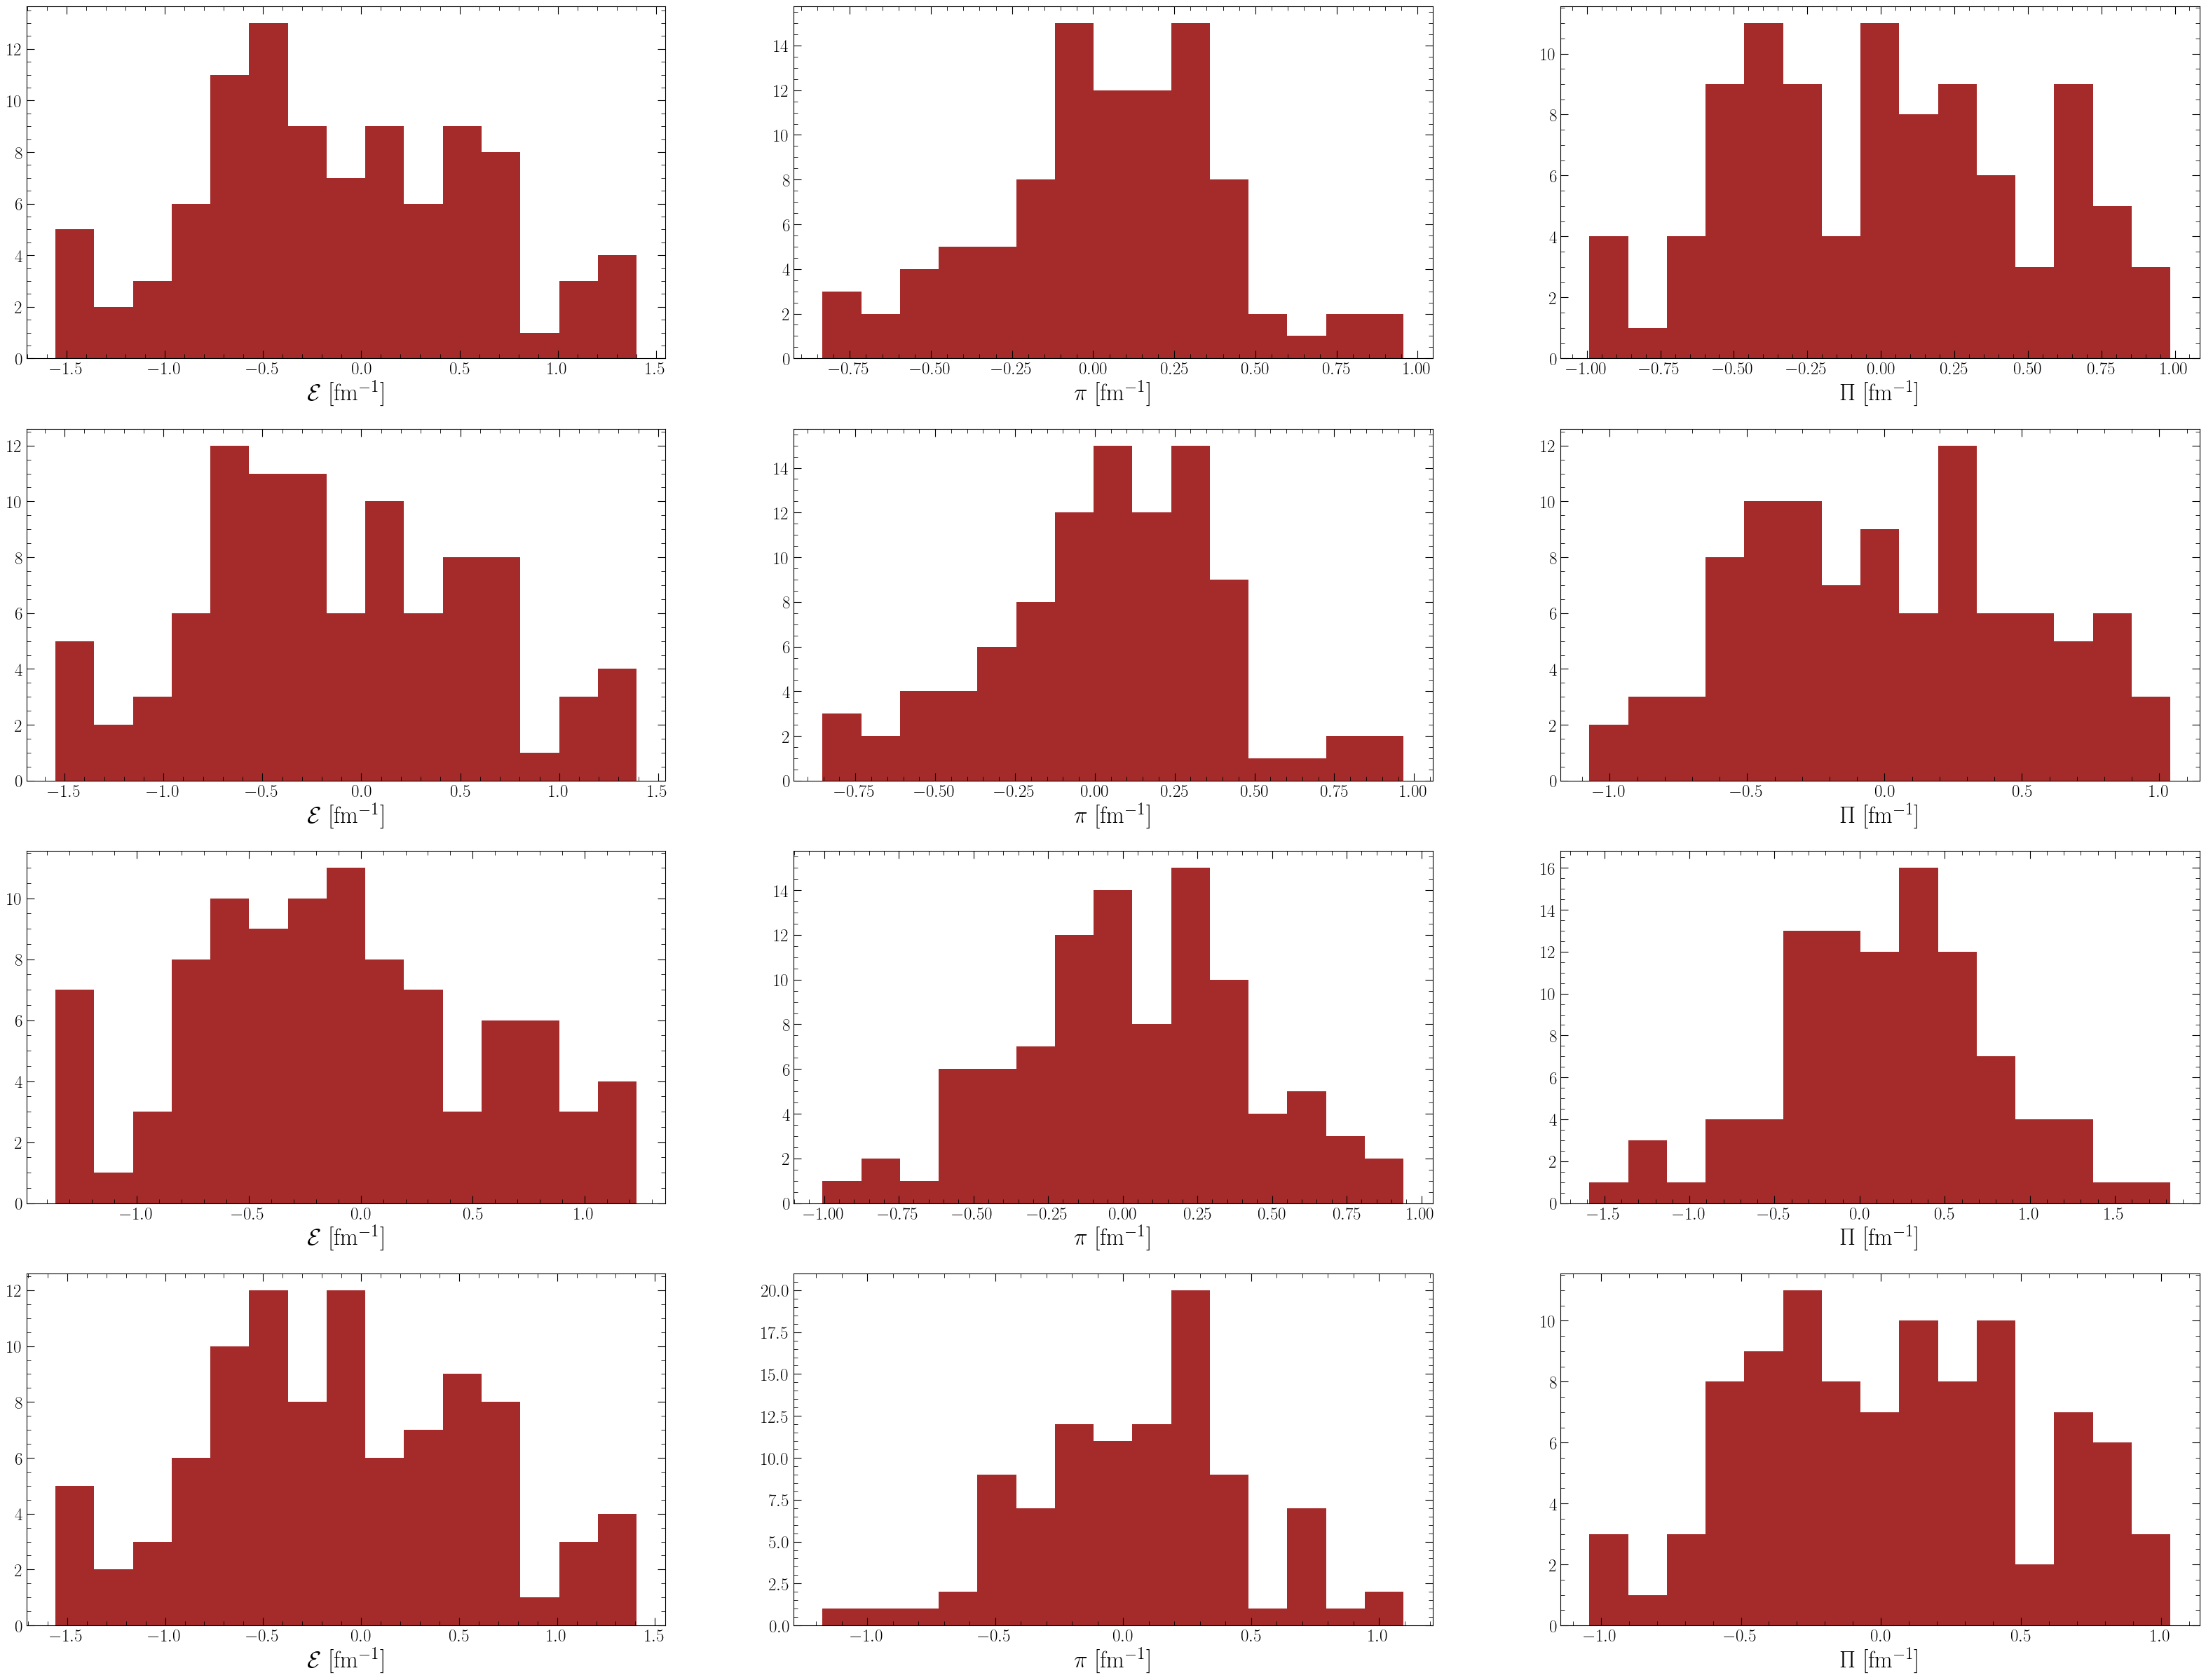

In [52]:
# Check error distribution to make sure it conforms to out assumptions
number_validation_points = 12
eta_s = np.array(GP_parameter_ranges[0,0] + np.random.rand(number_validation_points, 1) * GP_design_range[0])
eta_s = eta_s[np.argsort(eta_s, 0)[:,0]]
validation_points = eta_s

validate = True
read_in_validation_data = False
if validate:
    if read_in_validation_data:
        validation_data_file = open('validation_data.pkl', 'rb')
        validation_data = pickle.load(validation_data_file)
        validation_data_file.close()
    else:
        validation_data = dict((key, []) for key in names)
        for i, name in enumerate(names):
            params['hydro_type'] = i
            local_list = []
            for j, tau in enumerate(simulation_taus):
                params['tau_f'] = tau
                local_list.append(ProcessHydro(GP_parameter_names, validation_points))
            validation_data[name].append(local_list)
        
        validation_data_file = open('validation_data.pkl', 'wb')
        pickle.dump(validation_data, validation_data_file)
        validation_data_file.close()

    # This needs to be fixed: save the predictions to an output file as well
    GP_predictions = dict((key, []) for key in names)
    for name in names:
        for i in range(3):
            local_list = []
            for j, tau in enumerate(simulation_taus):
                GP_x_prediction, GP_x_err = emulators[name][j][i].predict(validation_points, return_std=True)
                local_list.append(np.hstack((GP_x_prediction, GP_x_err.reshape(-1,1))))
            GP_predictions[name].append(local_list)

    normalized_discrepenancy = dict((key, []) for key in names)
    for i, name in enumerate(names):
        for j in range(3):
            local_list = []
            for k in range(simulation_taus.size):
                local_list.append((np.array(GP_predictions[name])[j, k, :,0] - np.array(validation_data[name])[0, k, :, j+1]) / np.array(GP_predictions[name])[j, k, :,1])
            normalized_discrepenancy[name].append(np.array(local_list).reshape(-1,1))

    residuals = dict((key, []) for key in names)
    for i, name in enumerate(names):
        for j in range(3):
            local_list = []
            for k in range(simulation_taus.size):
                local_list.append((np.array(GP_predictions[name])[j, k, :,0] - np.array(validation_data[name])[0, k, :, j+1]))
            residuals[name].append(np.array(local_list).reshape(-1,1))

    fig1, ax1 = plt.subplots(4, 3, figsize=(40, 30))
    fig1.patch.set_facecolor('white')
    for i, name in enumerate(names):
        for j, observable in enumerate(observables):
            ax1[i, j].hist(residuals[name][j], color='brown')
            costumize_axis(ax1[i, j], observable, '')

    fig2, ax2 = plt.subplots(4, 3, figsize=(40, 30))
    fig2.patch.set_facecolor('white')
    for i, name in enumerate(names):
        for j, observable in enumerate(observables):
            ax2[i, j].hist(normalized_discrepenancy[name][j], bins=15, color='brown')
            costumize_axis(ax2[i, j], observable, '')

In [49]:
np.array(validation_data['ce']).shape

(1, 8, 12, 4)

In [53]:
def predict_observable(model_parameters, hydro_name, tau_index, GP_emulator):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array like (n,) 
    hydro_name          - string
    GP_emulator         - dictionary
    '''
    means = []
    variances = []
    for i in range(3):
        prediction, error = GP_emulator[hydro_name][tau_index][i].predict(np.array(model_parameters).reshape(-1, len(model_parameters)), return_std=True)
        means.append(prediction)
        variances.append(error ** 2)
    return np.hstack(means), np.diag(np.array(variances).flatten())

In [ ]:
x, y = predict_observable([0.33], 'ce', emulators)
print(x, y)

# Bayesian Inference
The usual

In [ ]:
def GetTemperature(e, m):
    def Eeq(T, z):
        if z == 0:
            return 3.0 * T ** 4 / np.pi ** 2
        else:
            return (3.0 * T ** 4 / np.pi ** 2) * (z ** 2 * special.kn(2, z) / 2.0 + z ** 3 * special.kn(1, z) / 6.0)

    Tmin = 0.001 / 0.197
    Tmax = 2.0 / 0.0197
    n = 0; flag = True
    Tmid = 0
    while flag and n <= 2000:
        Tmid = (Tmin + Tmax) / 2.0
        emid = Eeq(Tmid, m / Tmid)
        emin = Eeq(Tmin, m / Tmin)
        if np.fabs(emid - e) < 1e-6:
            break
        if (emid - e) * (emin - e) <= 0:
            Tmax = Tmid
        else:
            Tmin = Tmid
        n += 1
        if n == 1:
            Tcopy = Tmid
        if n > 4:
            if np.fabs(Tcopy - Tmid) < 1e-6:
                flag = False
            Tcopy = Tmid

    return Tmid * 0.197

In [ ]:
GetTemperature(12.4395115821926900, 0.2 / 0.197)

In [ ]:
true_parameters = [5 / (4 * np.pi)]
params['hydro_type'] = 4
true_observables = ProcessHydro(GP_parameter_names, true_parameters)
true_temperature = GetTemperature(true_observables[1], params['mass']) / 0.197

#true_observable_errors = [np.sqrt(true_observables[1]), np.sqrt(true_temperature ** 4 * np.fabs(true_observables[2])),np.sqrt(true_temperature ** 4 * np.fabs(true_observables[3]))]

In [ ]:
true_observable_errors = 0.0005 * np.fabs(true_observables[1:4])

In [ ]:
print(true_parameters)
print(true_observables)
print(true_observable_errors)

In [69]:
def log_prior(model_parameters, design_range):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array with shape (n,). Value of parameters used to evaluate model
    design_range        - 2d-array with shape (n,2). Give upper and lower limits of parameter values
    '''
    X  = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= np.array(design_range)[:,0])
    upper = np.all(X <= np.array(design_range)[:,1])

    if (lower and upper):
        return 0
    else:
        return -np.inf

def log_likelihood(y, cov):
    '''
    Parameters:
    ------------
    y   - 1d-array with shape (n,)
    cov - 2d-array with shape (n,n)
    '''
    # Use Cholesky decomposition for efficient lin alg algo
    L, info = lapack.dpotrf(cov, clean=True)

    if (info < 0):
        raise print('Error occured in computation of Cholesky decomposition')

    # Solve equation L*b=y
    b, info = lapack.dpotrs(L, np.array(y))

    if (info != 0):
        raise print('Error in inverting matrix equation')

    if np.all(L.diagonal() > 0):
        return -0.5 * np.dot(y, b) - np.log(L.diagonal()).sum()
    else:
        raise print('Diagonal has negative entry')

def log_posterior(model_parameters, design_range, true_observables, true_errors, hydro_name, GP_emulator):
    '''
    Parameters:
    ------------
    model_parameters    - 1d-array like (n,)  
    design_range        - 2d-array like (n,2)  
    hydro_name          - string containing hydro theory: 'ce', 'dnmr', 'vah', 'mvah'  
    GP_emulatr          - dictionary(hydro_name: emulator_list),  
                            emulator_list[0] - energery density  
                            emulator_list[1] - shear stress  
                            emulator_list[2] - bulk stress  
    '''
    running_log_likelihood = 0
    for k in range(true_observables.shape[0]):
        emulation_values, emulation_variance = predict_observable(model_parameters, hydro_name, k, GP_emulator) 

        y = np.array(emulation_values).flatten() - np.array(true_observables[k]).flatten()
        cov = emulation_variance + np.diag(true_errors) ** 2

        running_log_likelihood += log_likelihood(y.flatten(), cov)

    return log_prior(model_parameters, design_range) + running_log_likelihood


In [97]:
nparams = len(GP_parameter_names)
nwalkers = 20 * nparams
nburn = 500
nsteps = 2000

names = ['ce', 'dnmr', 'vah', 'mvah']
MCMC_samplers = {}
for i, name in enumerate(names):
    print(f"Computing for hydro theory: {name}")
    starting_guesses = GP_parameter_ranges[:,0] + np.random.rand(nwalkers, nparams) * GP_design_range
    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, nparams, log_posterior, args=(GP_parameter_ranges, exact_pseudo[:, 1:4], exact_error, name, emulators))
        print('burn in sampling started')    
        pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
        print('Burn in completed.')
        print("Now running the samples")
        sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
    sampler_df = pd.DataFrame(sampler.get_chain(flat=True, discard=nburn), columns=GP_parameter_names_math)
    MCMC_samplers[name] = sampler_df

Computing for hydro theory: ce
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers
burn in sampling started


100%|██████████| 500/500 [00:45<00:00, 10.89it/s]


Mean acceptance fraction: 0.791 (in total 10000 steps)
Burn in completed.
Now running the samples


100%|██████████| 2000/2000 [02:34<00:00, 12.98it/s]

Mean acceptance fraction: 0.803 (in total 40000 steps)
Computing for hydro theory: dnmr
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers


burn in sampling started


100%|██████████| 500/500 [00:37<00:00, 13.40it/s]


Mean acceptance fraction: 0.806 (in total 10000 steps)
Burn in completed.
Now running the samples


100%|██████████| 2000/2000 [02:29<00:00, 13.41it/s]

Mean acceptance fraction: 0.807 (in total 40000 steps)
Computing for hydro theory: vah
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers


burn in sampling started


100%|██████████| 500/500 [00:37<00:00, 13.51it/s]


Mean acceptance fraction: 0.804 (in total 10000 steps)
Burn in completed.
Now running the samples


100%|██████████| 2000/2000 [02:25<00:00, 13.75it/s]

Mean acceptance fraction: 0.807 (in total 40000 steps)
Computing for hydro theory: mvah
MCMC sampling using emcee (affine-invariant ensamble sampler) with 20 walkers


burn in sampling started


100%|██████████| 500/500 [00:37<00:00, 13.47it/s]


Mean acceptance fraction: 0.802 (in total 10000 steps)
Burn in completed.
Now running the samples


100%|██████████| 2000/2000 [02:30<00:00, 13.32it/s]

Mean acceptance fraction: 0.804 (in total 40000 steps)


In [ ]:
sampler_df.head()

In [ ]:
observables

## My own sampler

In [64]:
np.array(emulators['ce']).shape

(8, 3)

In [70]:
steps = 1000
sampler_params = np.linspace(GP_parameter_ranges[0,0], GP_parameter_ranges[0,1], steps)
posteriors = {}
for i, name in enumerate(names):
    final_arr = np.zeros(steps)
    for j in range(steps):
        final_arr[j] = log_posterior([sampler_params[j]], GP_parameter_ranges, exact_pseudo[:, 1:4], exact_error, name, emulators)
    posteriors[name] = final_arr

<ipython-input-92-73a4a83dbefb>:21: RuntimeWarning: invalid value encountered in true_divide
  ax[k, 0].plot(sampler_params, np.exp(np.array(posteriors[name], dtype=np.float128)) / np.sum(np.exp(np.array(posteriors[name], dtype=np.float128))), label=name)
<ipython-input-92-73a4a83dbefb>:21: RuntimeWarning: invalid value encountered in true_divide
  ax[k, 0].plot(sampler_params, np.exp(np.array(posteriors[name], dtype=np.float128)) / np.sum(np.exp(np.array(posteriors[name], dtype=np.float128))), label=name)
<ipython-input-92-73a4a83dbefb>:21: RuntimeWarning: invalid value encountered in true_divide
  ax[k, 0].plot(sampler_params, np.exp(np.array(posteriors[name], dtype=np.float128)) / np.sum(np.exp(np.array(posteriors[name], dtype=np.float128))), label=name)
<ipython-input-92-73a4a83dbefb>:21: RuntimeWarning: invalid value encountered in true_divide
  ax[k, 0].plot(sampler_params, np.exp(np.array(posteriors[name], dtype=np.float128)) / np.sum(np.exp(np.array(posteriors[name], dtype=np.f

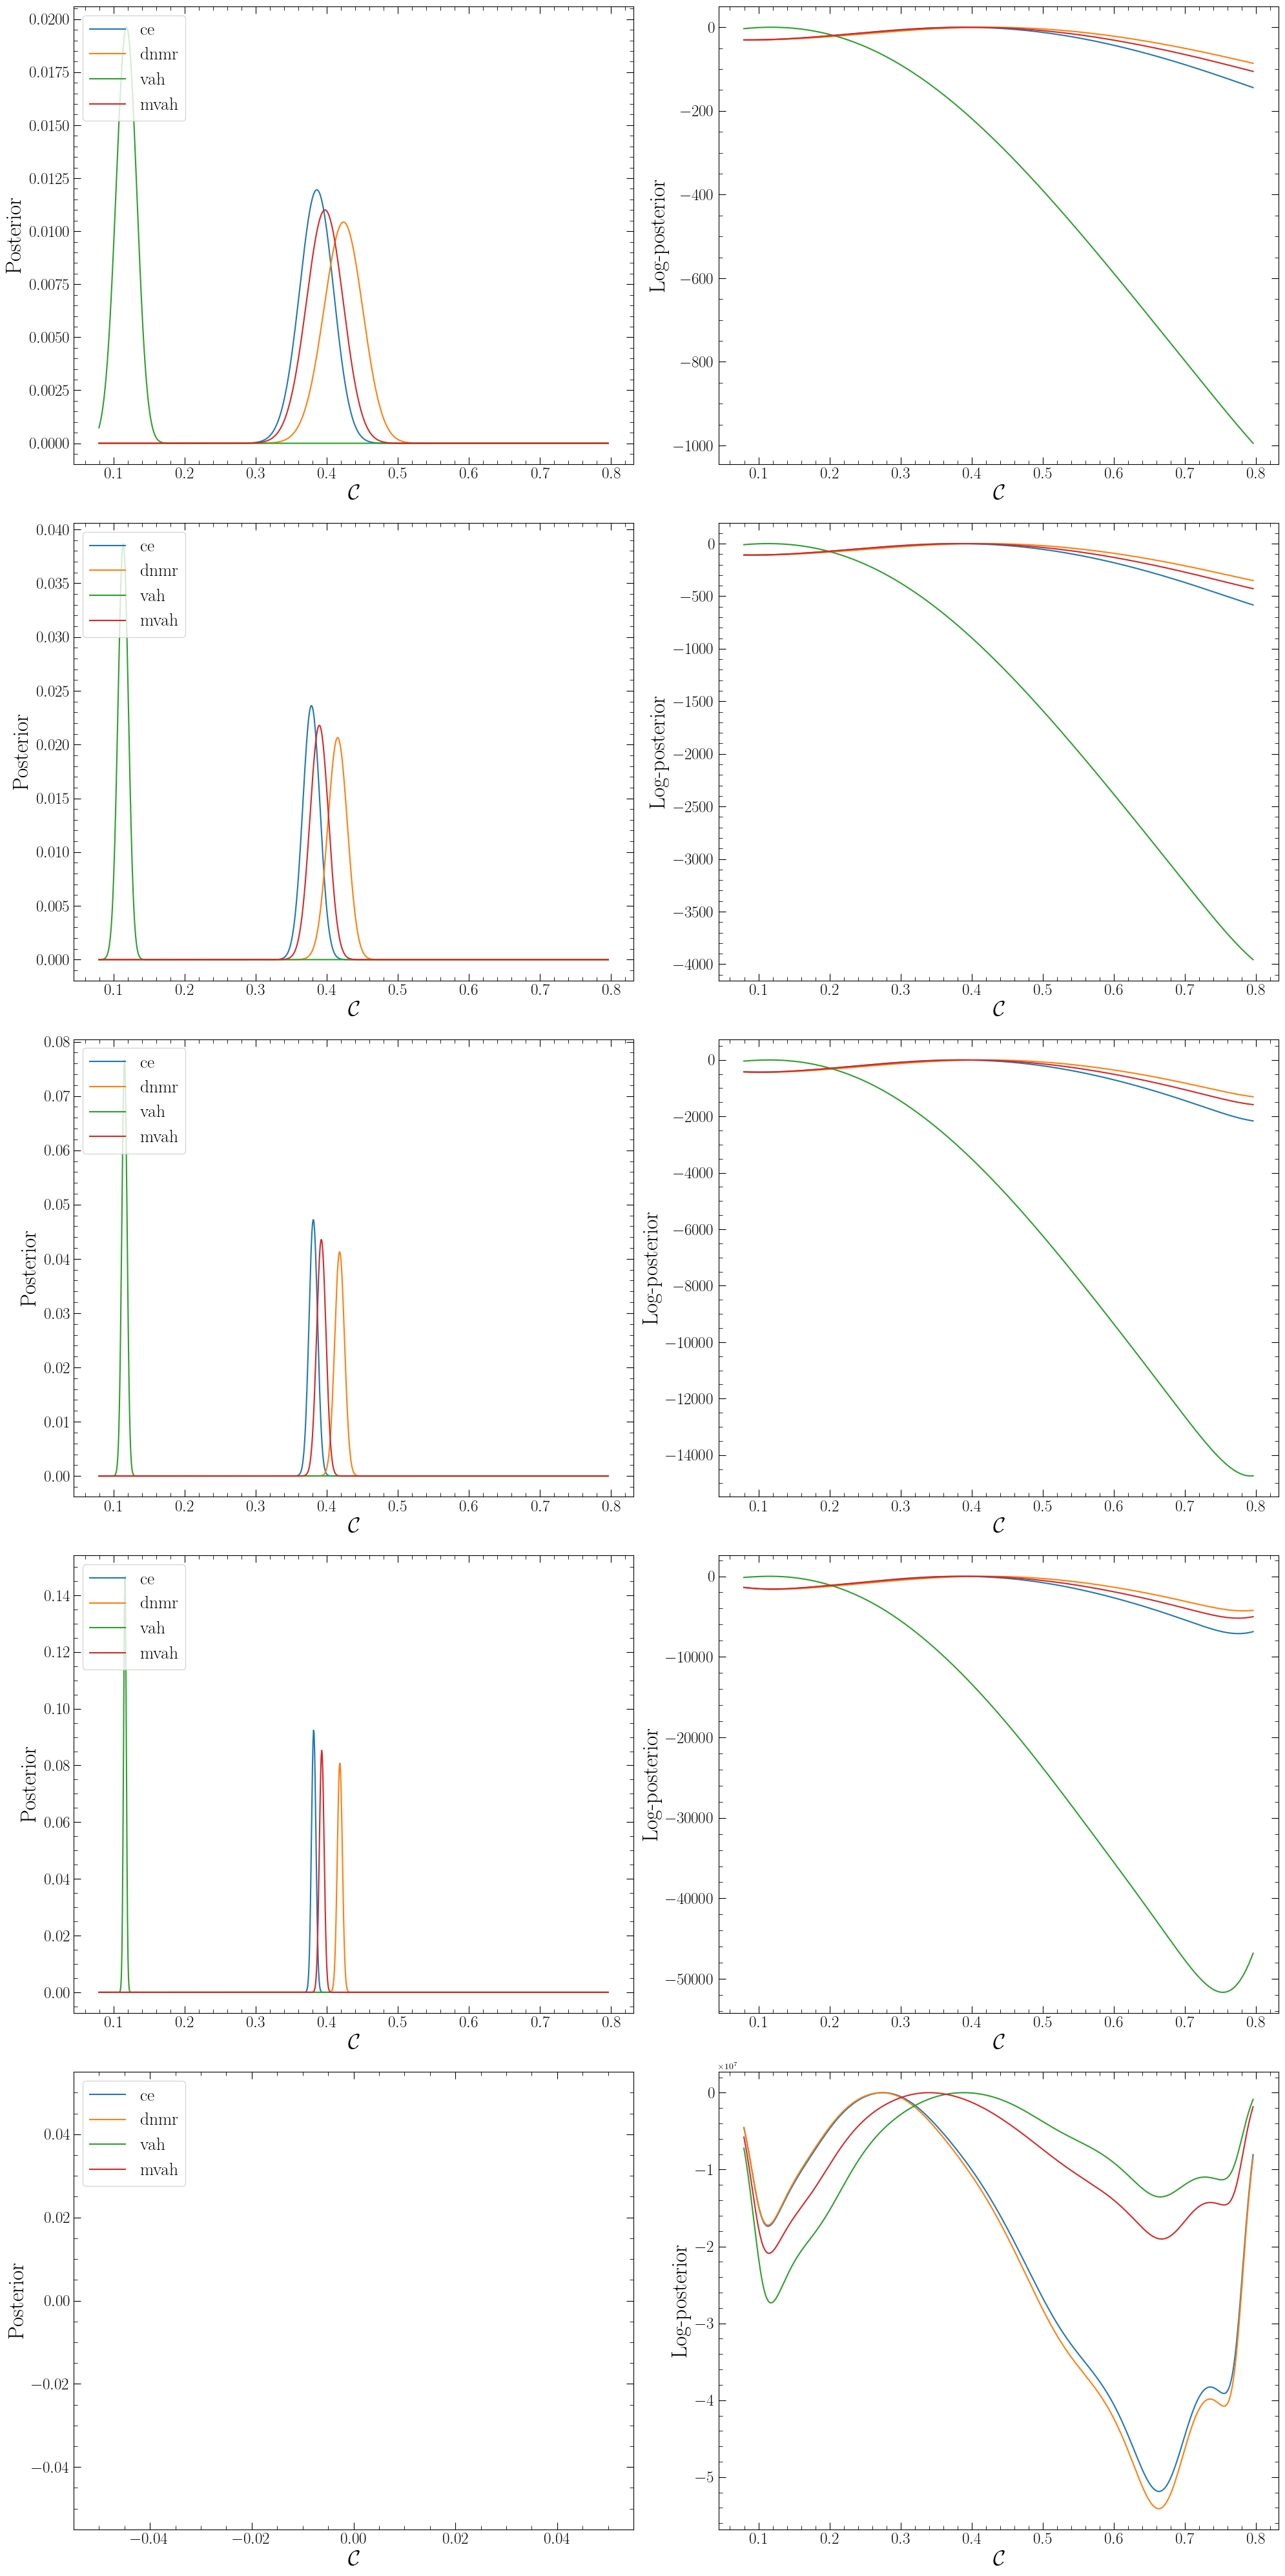

In [92]:
fig, ax = plt.subplots(5, 2, figsize=(20, 40))
alpha_error = [0.5, 0.25, 0.125, 0.0625, 0.0]
for k, err in enumerate(alpha_error):
    pseudo_err = err * exact_out[:, 1:4]
    pseudo_dat = np.array([[np.random.normal(loc=obv, scale=0.05 * obv) for obv in exact] for exact in exact_out])
    for i, tau in enumerate(simulation_taus):
        exact_pseudo[i, 0] = tau
    steps = 1000
    sampler_params = np.linspace(GP_parameter_ranges[0,0], GP_parameter_ranges[0,1], steps)
    posteriors = {}
    for i, name in enumerate(names):
        final_arr = np.zeros(steps)
        for j in range(steps):
            final_arr[j] = log_posterior([sampler_params[j]], GP_parameter_ranges, pseudo_dat[:, 1:4], pseudo_err, name, emulators)
        posteriors[name] = final_arr

    for i, name in enumerate(names):
        if False:
            ax[k, 0].plot(sampler_params, np.exp(posteriors[name] - np.max(posteriors[name])), label=name)
        else:
            ax[k, 0].plot(sampler_params, np.exp(np.array(posteriors[name], dtype=np.float128)) / np.sum(np.exp(np.array(posteriors[name], dtype=np.float128))), label=name)
        ax[k, 1].plot(sampler_params, posteriors[name] - np.max(posteriors[name]))
    ax[k, 0].legend(loc='upper right', fontsize=20)
    costumize_axis(ax[k, 0], r'$\mathcal C$', 'Posterior')
    costumize_axis(ax[k, 1], r'$\mathcal C$', 'Log-posterior')
fig.tight_layout()
fig.savefig('plots/1param-posterior-compare-errors1.pdf')

In [ ]:
for name in names:
    print(posteriors[name])

[-5.82776691e+06 -6.15865317e+06 -6.49924919e+06 -6.84946483e+06
 -7.20915319e+06 -7.57811114e+06 -7.95607104e+06 -8.34269606e+06
 -8.73758008e+06 -9.14023894e+06 -9.55011232e+06 -9.96655781e+06
 -1.03888530e+07 -1.08161947e+07 -1.12476976e+07 -1.16824024e+07
 -1.21192741e+07 -1.25572128e+07 -1.29950562e+07 -1.34315918e+07
 -1.38655652e+07 -1.42956905e+07 -1.47206630e+07 -1.51391719e+07
 -1.55499165e+07 -1.59516133e+07 -1.63430150e+07 -1.67229215e+07
 -1.70901939e+07 -1.74437637e+07 -1.77826436e+07 -1.81059397e+07
 -1.84128546e+07 -1.87026974e+07 -1.89748835e+07 -1.92289417e+07
 -1.94645156e+07 -1.96813545e+07 -1.98793241e+07 -2.00583935e+07
 -2.02186340e+07 -2.03602139e+07 -2.04833896e+07 -2.05885041e+07
 -2.06759707e+07 -2.07462708e+07 -2.07999443e+07 -2.08375834e+07
 -2.08598186e+07 -2.08673159e+07 -2.08607680e+07 -2.08408851e+07
 -2.08083905e+07 -2.07640133e+07 -2.07084804e+07 -2.06425163e+07
 -2.05668352e+07 -2.04821362e+07 -2.03891022e+07 -2.02883970e+07
 -2.01806578e+07 -2.00665

## Validation: Autocorrelation

In [109]:
def autocorrelation(chain, max_lag=100):
    dim = len(chain)
    acorr = np.empty(max_lag+1)
    if max_lag > dim / 5:
        print('max_lag is more than a 5th the chain length')
    
    chain1d = chain - np.average(chain)
    for lag in range(max_lag + 1):
        unshifted = None
        shifted = chain1d[lag:]
        if lag == 0:
            unshifted = chain1d
        else:
            unshifted = chain1d[:-lag]
        normalization = np.sqrt(np.dot(unshifted, unshifted))
        normalization *= np.sqrt(np.dot(shifted, shifted))
        acorr[lag] = np.dot(shifted, unshifted) / normalization
    return acorr

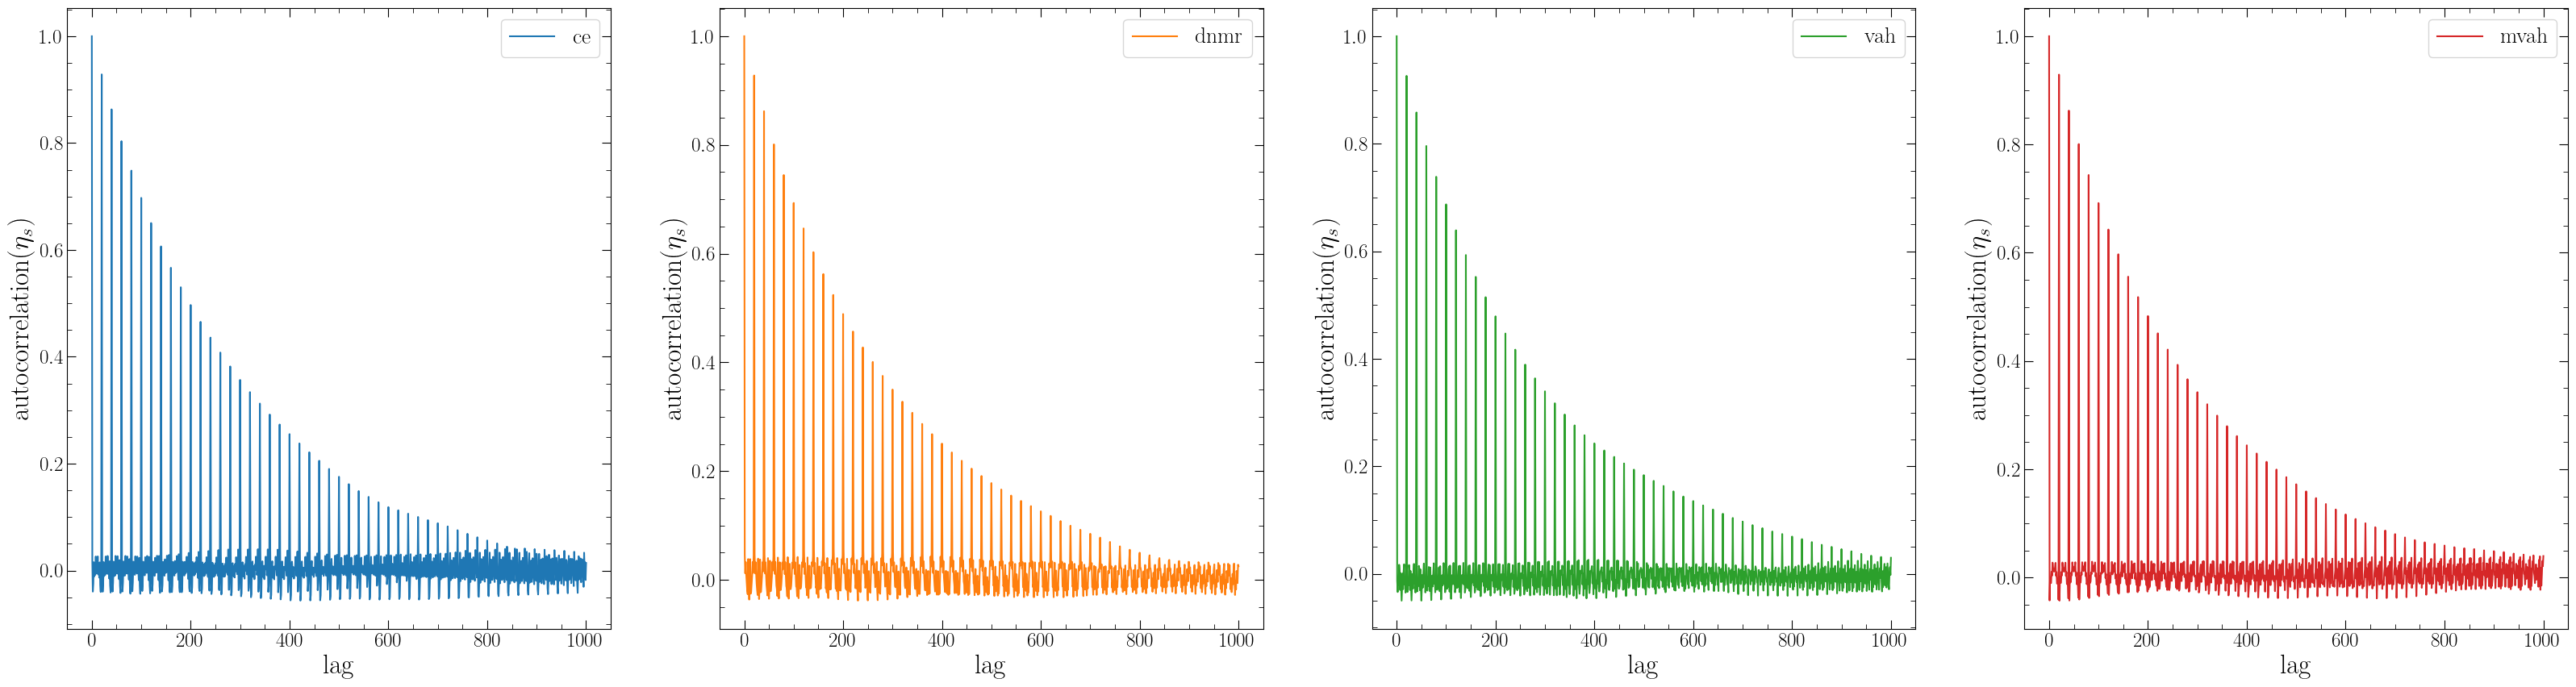

In [118]:
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
fig.patch.set_facecolor('white')
cmap=get_cmap(10, 'tab10')
for irow, name in enumerate(names):
    for jcol, param in enumerate(GP_parameter_names_math):
        acorr = autocorrelation(MCMC_samplers[name].iloc[:,jcol].to_numpy(), 1000)
        ax[irow].plot(acorr, color=cmap(irow), label=name)
        costumize_axis(ax[irow], 'lag', 'autocorrelation(' + param + ')')
        ax[irow].legend(loc='upper right', fontsize=20)
    

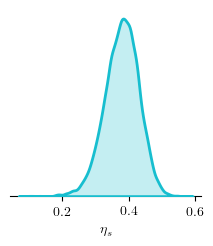

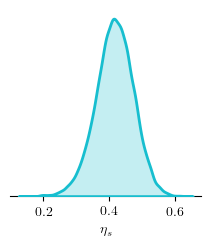

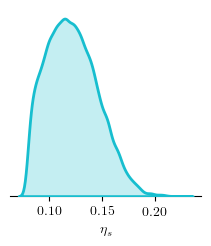

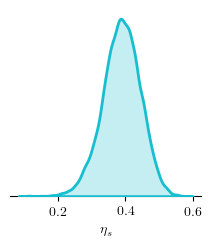

In [100]:
names = ['ce', 'dnmr', 'vah', 'mvah']
for i, name in enumerate(names):
    g = sns.PairGrid(MCMC_samplers[name].iloc[:,:], corner=True, diag_sharey=False)
    g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
    g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
    # for n in range(nparams):
    #     ax=g.axes[n][n]
    #     ax.axvline(x=true_parameters[n], ls='-', c=sns.color_palette()[3], label='Truth')
    #     ax.text(0,0.8,s= f'{true_parameters[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[1], fontsize=12)
    # g.axes.legend(loc='best', fontsize=10)
    # g.axes.text(0.5 ,0.8, s=name, color=sns.color_palette()[1], fontsize=12)

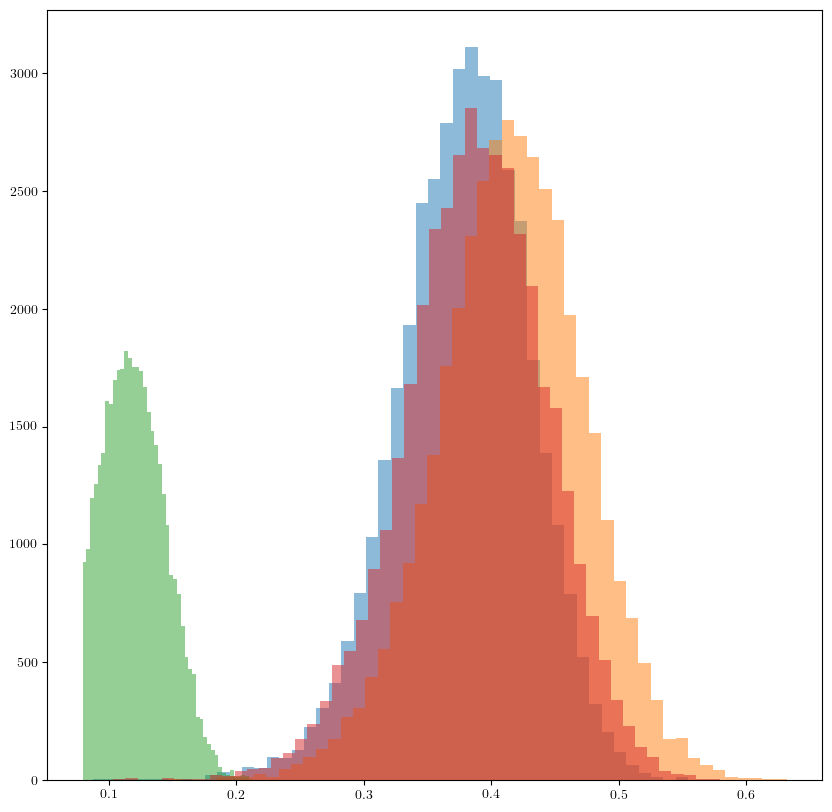

In [145]:
fig, ax = plt.subplots(figsize=(10,10))
fig.patch.set_facecolor('white')

cmap=get_cmap(10, 'tab10')
for i, name in enumerate(names):
    ax.hist(MCMC_samplers[name].iloc[:,0], bins=50, lw=2, color=cmap(i), alpha=.5)

In [141]:
print(my_hist[0].shape)
print(my_hist[1].shape)
my_hist

(20,)
(21,)


(array([  15,    9,   11,   41,  118,  228,  557, 1220, 2106, 3575, 5590,
        6697, 6644, 5702, 3880, 2204,  968,  342,   77,   16]),
 array([0.1036448 , 0.12743705, 0.15122931, 0.17502156, 0.19881381,
        0.22260607, 0.24639832, 0.27019057, 0.29398283, 0.31777508,
        0.34156733, 0.36535959, 0.38915184, 0.41294409, 0.43673635,
        0.4605286 , 0.48432085, 0.5081131 , 0.53190536, 0.55569761,
        0.57948986]))

In [ ]:
from IPython.display import display, Math
parameter_names = [r'\eta/\mathcal{S}', r'\tau_f']
for name in names:
    print(f'Prediction of {name}:')
    for i in range(num_parameters_in_GP):
        mcmc = np.percentile(MCMC_samplers[name].to_numpy()[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        output = '{{{1}}}= {2:.3f}^{{+{3:.3f}}}_{{-{4:.3f}}}'.format(name, parameter_names[i], mcmc[1], q[1], q[0])
        display(Math(output))
    print('\n')